In [16]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import tqdm_notebook, tnrange
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate,add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array,load_img,array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob

In [17]:
def count_img(root, total, folders, total_count, text):
    for filename in tqdm(os.listdir(root)):
        if filename != ".DS_Store":
            folders.append(filename)
            ids = next(os.walk(root+'/'+filename))[2]# list of names all images in the given path
            total_count.append(len(ids))
            total +=len(ids)
    print(text)
    print("Number of images and masks = ", total)
    print("The folders containing images and masks are :", folders)
    print("Image tally accordingly :", total_count)
    return total, folders, total_count

In [18]:
def mac_equalizer(total_count):
    for i in range(len(total_count)):
        if total_count[i] % 2 != 0 :
            total_count[i] -= 1
    print("New count is :", total_count)
    print("New total = ", sum(total_count))
    return total_count,sum(total_count)

In [19]:
def upload(root, folders, X, y, text):
    count_img = 0
    count_mask = 0
    
    print(text)
    
    for file in folders : 
        image_dir_path = root+ "/" +file
        mask_dir_path =  root+ "/" +file
        
        for img_path in tqdm(sorted(glob.glob(os.path.join(image_dir_path, "*_img.png")))):
            img = load_img(img_path, color_mode = "grayscale")
            img = img_to_array(img)
            img = resize(img, (512, 512, 1), mode = 'constant', preserve_range = True)
            img = img/255.0
            X[count_img]=img 
            count_img+=1
        print("Image upload count = ", count_img)
        
        
        for mask_path in tqdm(sorted(glob.glob(os.path.join(mask_dir_path, "*_mask.png")))):
            mask = load_img(mask_path, color_mode = "grayscale")
            mask = img_to_array(mask)
            mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
            mask = mask/255.0
            y[count_mask]=mask
            count_mask+=1
        print("Mask upload count = ", count_mask)
    return X,y

In [20]:
def pre_visualize(X, y, text, ix = None) :
    
    print(text)
    for i in range(5) : 
        if ix == None :
            ix = random.randint(0, len(X)-1)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
        ax1.imshow(X[ix], cmap = 'gray', interpolation = 'bilinear')
        ax1.set_title('Image')
        
        ax2.imshow(y[ix], cmap = 'gray', interpolation = 'bilinear')
        ax2.set_title('Mask')

In [21]:
train_text = "\t\t\t\t\t\tTraining "
valid_text = "\t\t\t\t\t\tValidation "
test_text = "\t\t\t\t\t\t\tTesting "
train_total = 0
test_total = 0
train_total_count = []
test_total_count = []
train_folders = []
test_folders = []
train_root = "/Users/anveshsk/Dropbox/capstone_data/train_global"
test_root = "/Users/anveshsk/Dropbox/capstone_data/test"


train_total, train_folders, train_total_count = count_img(train_root, train_total, train_folders, train_total_count, "Training")
test_total, test_folders, test_total_count = count_img(test_root, test_total, test_folders, test_total_count, "Testing")


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 2700.06it/s]


Training
Number of images and masks =  902
The folders containing images and masks are : ['EA_045_RenTha', '14335535+img+mask', '14373928+img+mask', '84+img+mask', 'EA_027_img+mask', 'EA_047+img+mask', 'EA_036_BhaKha', 'EA_050_PraMha', 'EA_031_ShaShe', 'EA_043+img+mask', 'EA_026_LilCha', '14235776+img+mask', 'EA_028+img+mask', 'EA_039+img+mask', '14453086+img+mask', '14424038+img+mask']
Image tally accordingly : [56, 48, 46, 46, 44, 52, 44, 50, 156, 38, 42, 62, 60, 54, 62, 42]


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 2410.52it/s]

Testing
Number of images and masks =  54
The folders containing images and masks are : ['SS_EA001', 'SS_EA041', 'SS_EA025', 'SS_EA034', 'SS_EA002']
Image tally accordingly : [10, 10, 10, 13, 11]


In [22]:
train_total_count, train_total = mac_equalizer(train_total_count)
test_total_count, test_total = mac_equalizer(test_total_count)

New count is : [56, 48, 46, 46, 44, 52, 44, 50, 156, 38, 42, 62, 60, 54, 62, 42]
New total =  902
New count is : [10, 10, 10, 12, 10]
New total =  52


In [23]:
im_width = 512
im_height = 512

X = np.zeros((int(train_total/2), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((int(train_total/2), im_height, im_width, 1), dtype=np.float32)

X_test = np.zeros((int(test_total/2), im_height, im_width, 1), dtype=np.float32)
y_test = np.zeros((int(test_total/2), im_height, im_width, 1), dtype=np.float32)

In [24]:
X, y = upload(train_root, train_folders, X, y, train_text)

						Training 


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 37.81it/s]


Image upload count =  28


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 44.96it/s]


Mask upload count =  28


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 39.29it/s]


Image upload count =  52


100%|███████████████████████████████████████████| 24/24 [00:00<00:00, 45.58it/s]


Mask upload count =  52


100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 40.02it/s]


Image upload count =  75


100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 45.44it/s]


Mask upload count =  75


100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 39.28it/s]


Image upload count =  98


100%|███████████████████████████████████████████| 23/23 [00:00<00:00, 45.43it/s]


Mask upload count =  98


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 39.25it/s]


Image upload count =  120


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 45.48it/s]


Mask upload count =  120


100%|███████████████████████████████████████████| 26/26 [00:00<00:00, 41.06it/s]


Image upload count =  146


100%|███████████████████████████████████████████| 26/26 [00:00<00:00, 45.47it/s]


Mask upload count =  146


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 40.42it/s]


Image upload count =  168


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 45.13it/s]


Mask upload count =  168


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 34.80it/s]


Image upload count =  193


100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 41.44it/s]


Mask upload count =  193


100%|███████████████████████████████████████████| 78/78 [00:02<00:00, 34.45it/s]


Image upload count =  271


100%|███████████████████████████████████████████| 78/78 [00:02<00:00, 38.15it/s]


Mask upload count =  271


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 39.33it/s]


Image upload count =  290


100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 44.23it/s]


Mask upload count =  290


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 27.62it/s]


Image upload count =  311


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 28.73it/s]


Mask upload count =  311


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 37.34it/s]


Image upload count =  342


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 41.77it/s]


Mask upload count =  342


100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 36.01it/s]


Image upload count =  372


100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 38.71it/s]


Mask upload count =  372


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 31.73it/s]


Image upload count =  399


100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 38.63it/s]


Mask upload count =  399


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 38.92it/s]


Image upload count =  430


100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 43.82it/s]


Mask upload count =  430


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 40.38it/s]


Image upload count =  451


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 35.21it/s]

Mask upload count =  451


In [25]:
X_test, y_test = upload(test_root, test_folders, X_test, y_test, test_text)

							Testing 


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 31.75it/s]


Image upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 34.55it/s]


Mask upload count =  5


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 29.89it/s]


Image upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 31.81it/s]


Mask upload count =  10


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 30.06it/s]


Image upload count =  15


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 32.77it/s]


Mask upload count =  15


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 28.47it/s]


Image upload count =  21


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 42.58it/s]


Mask upload count =  21


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 33.57it/s]


Image upload count =  26


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 36.31it/s]

Mask upload count =  26


In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [27]:
len(X_train)

360

In [28]:
len(X_valid)

91

						Training 


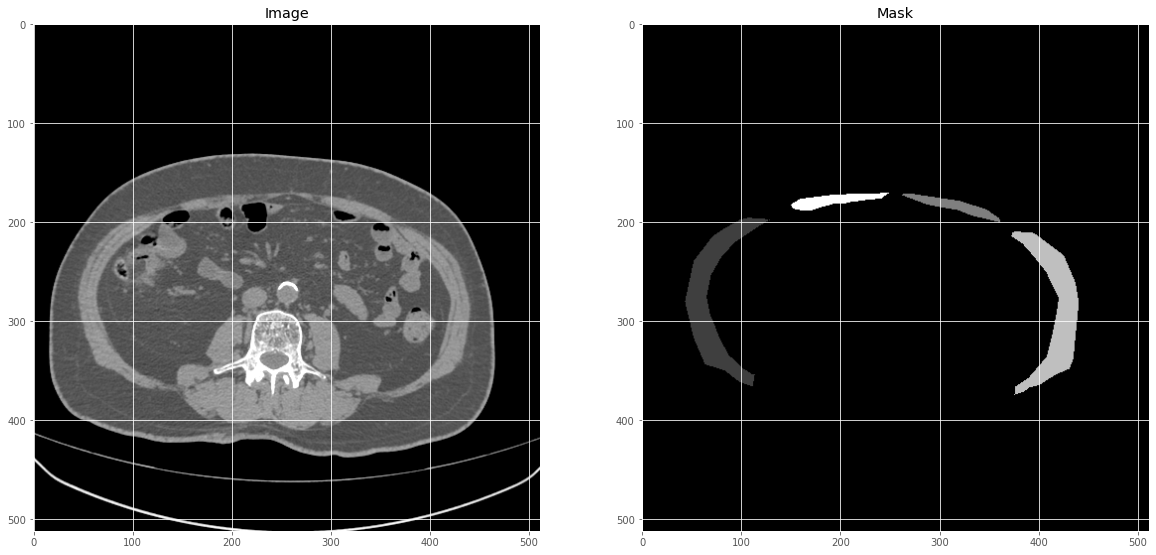

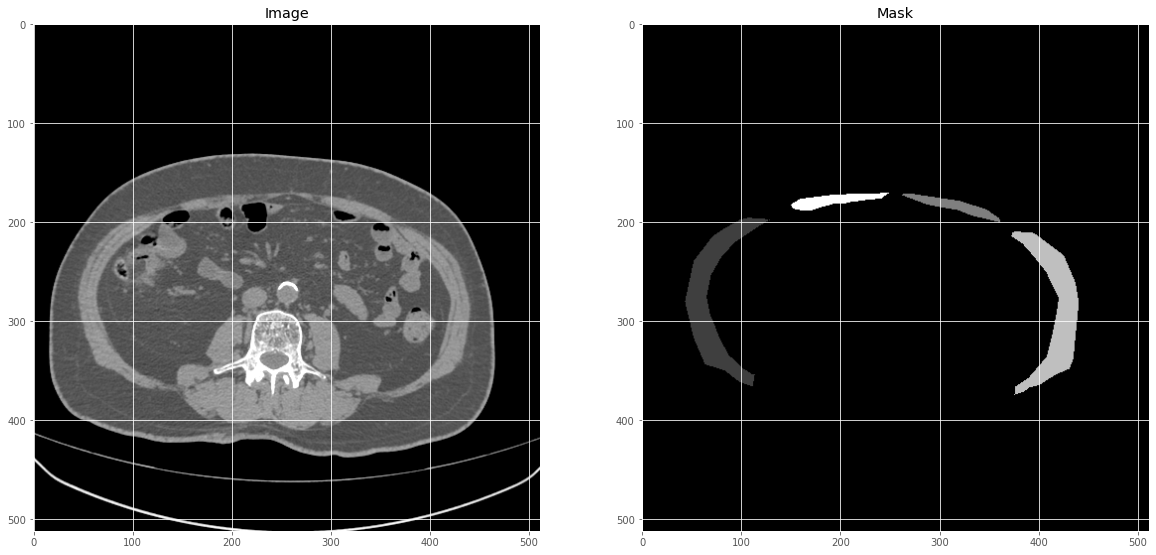

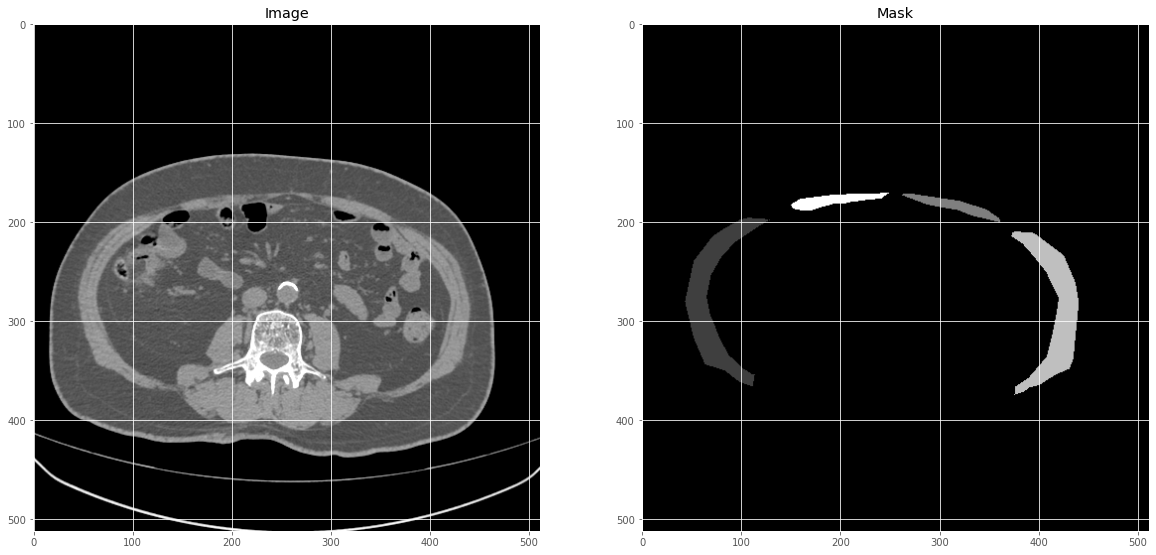

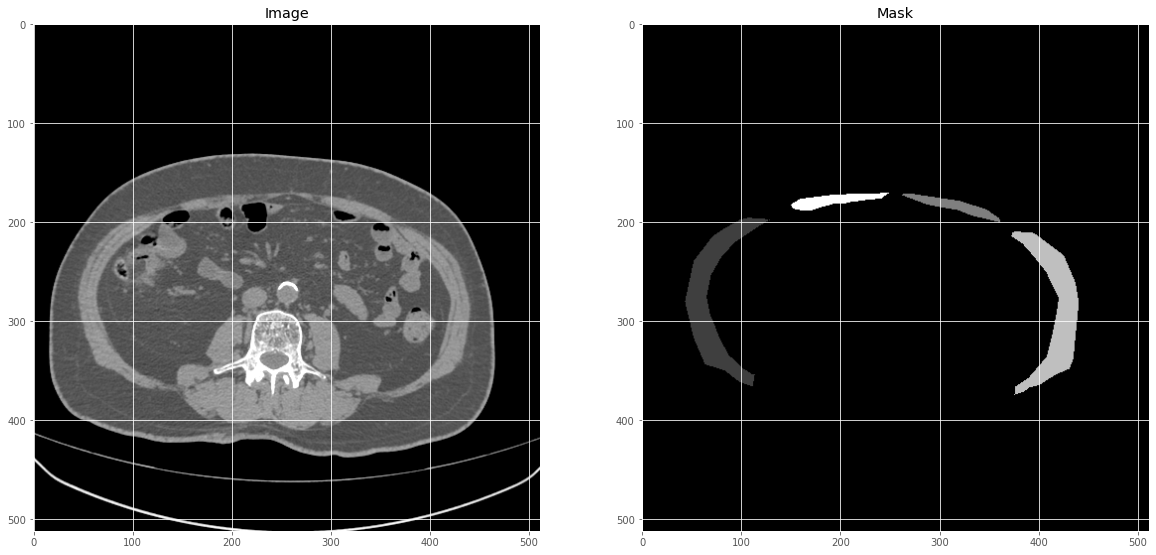

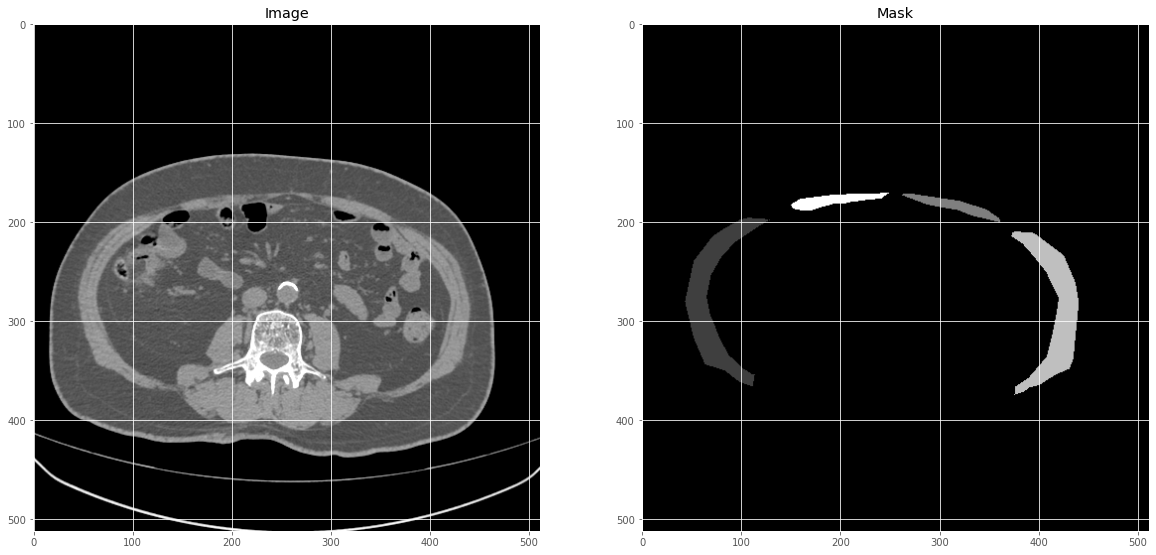

In [29]:
pre_visualize(X_train, y_train, train_text)

						Validation 


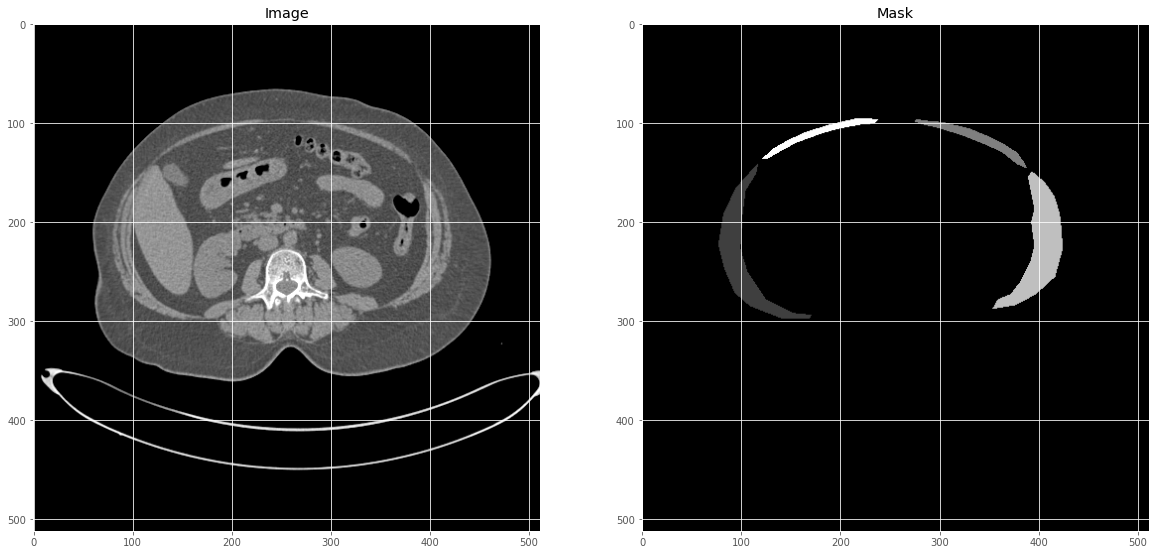

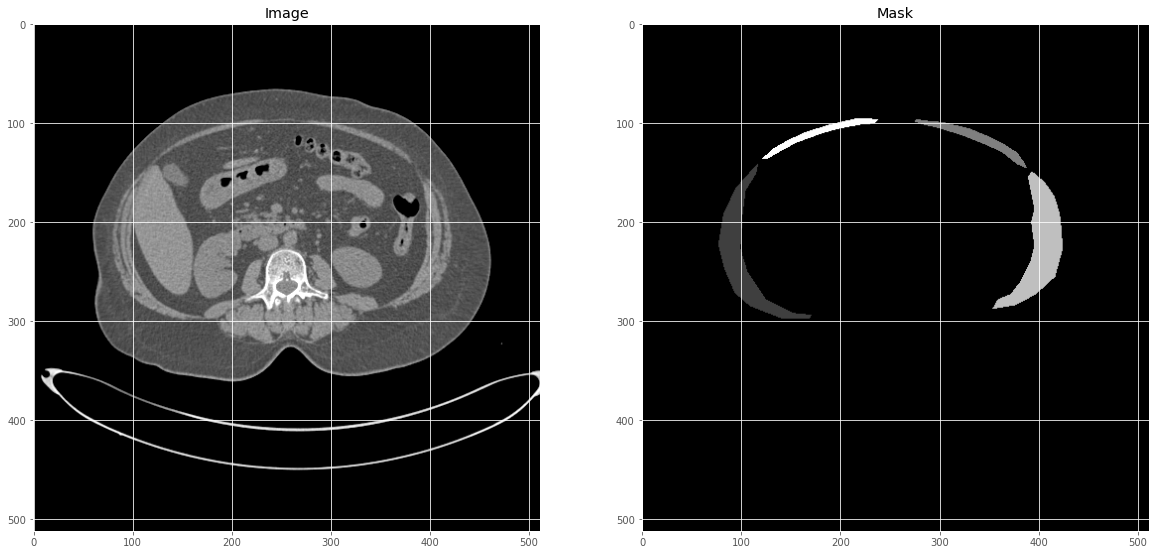

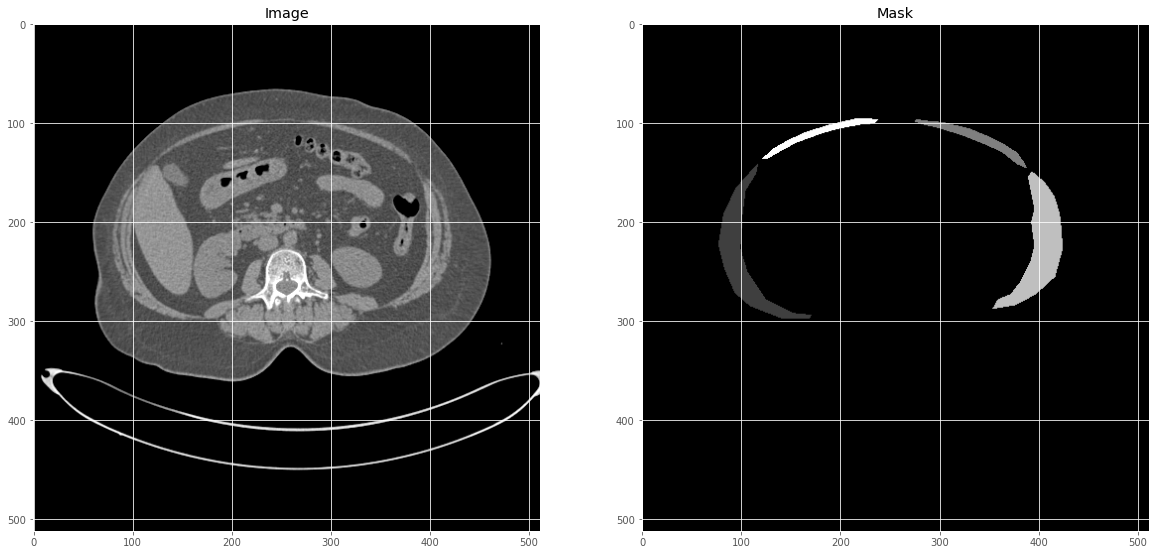

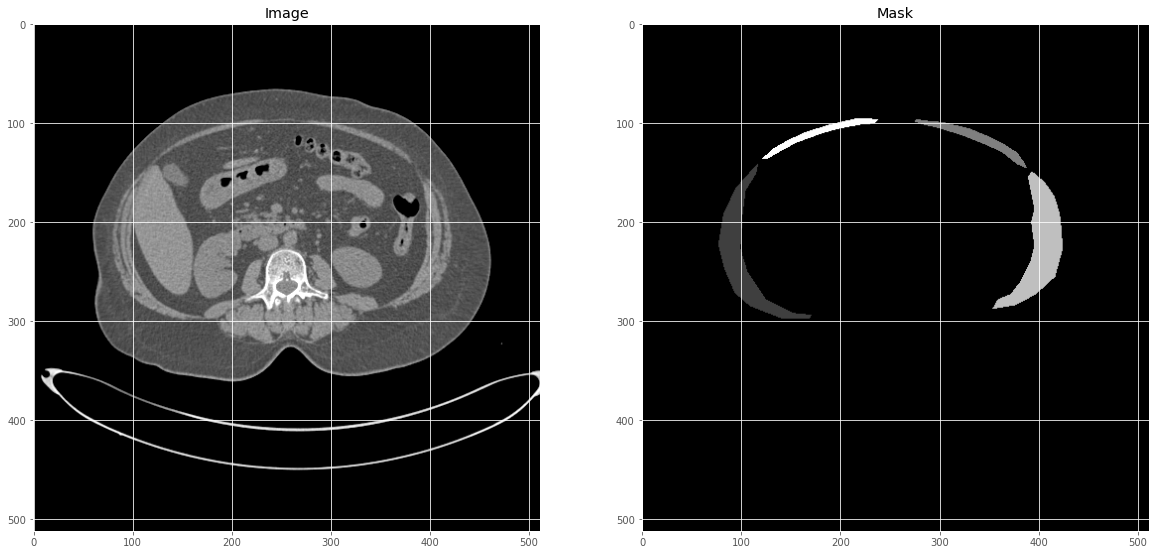

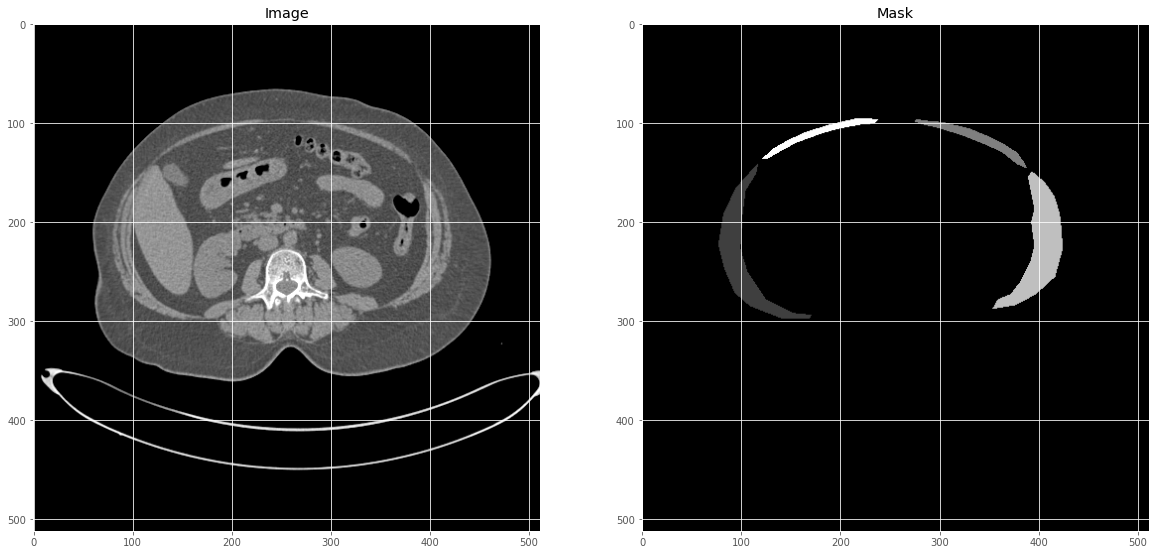

In [30]:
pre_visualize(X_valid, y_valid, valid_text)

							Testing 


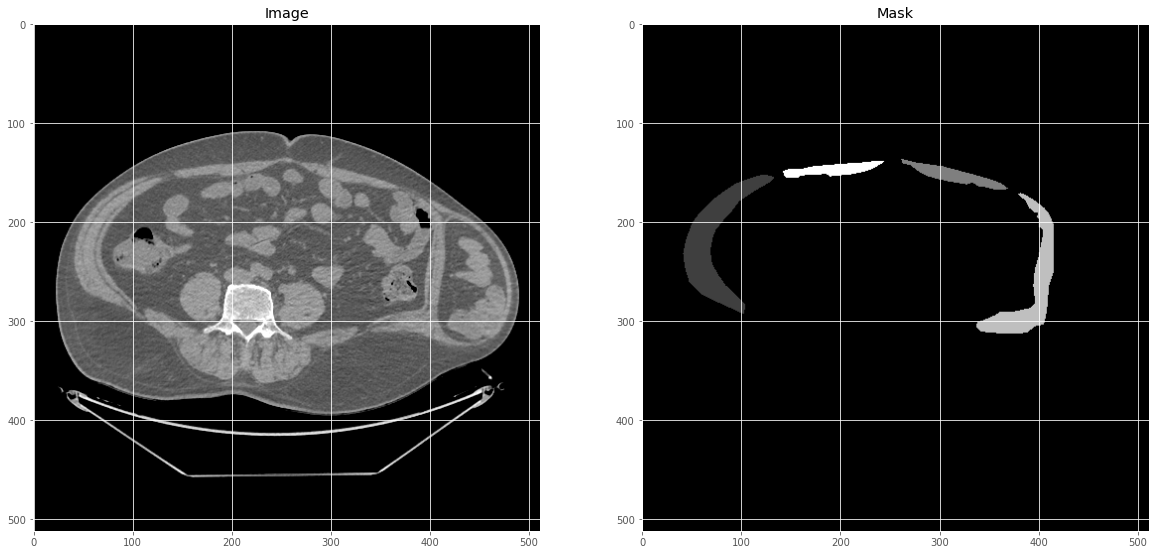

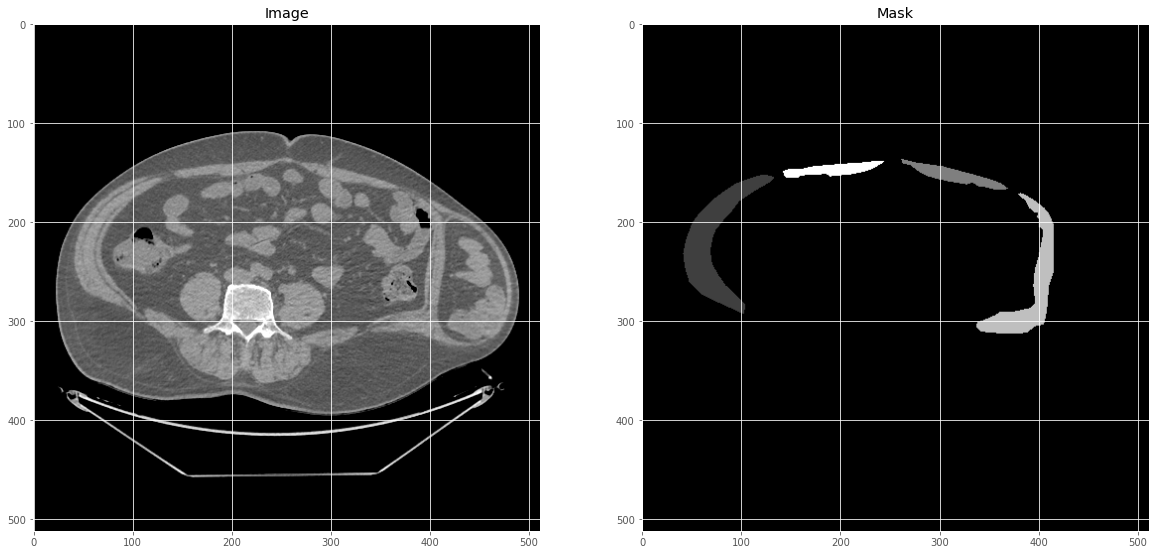

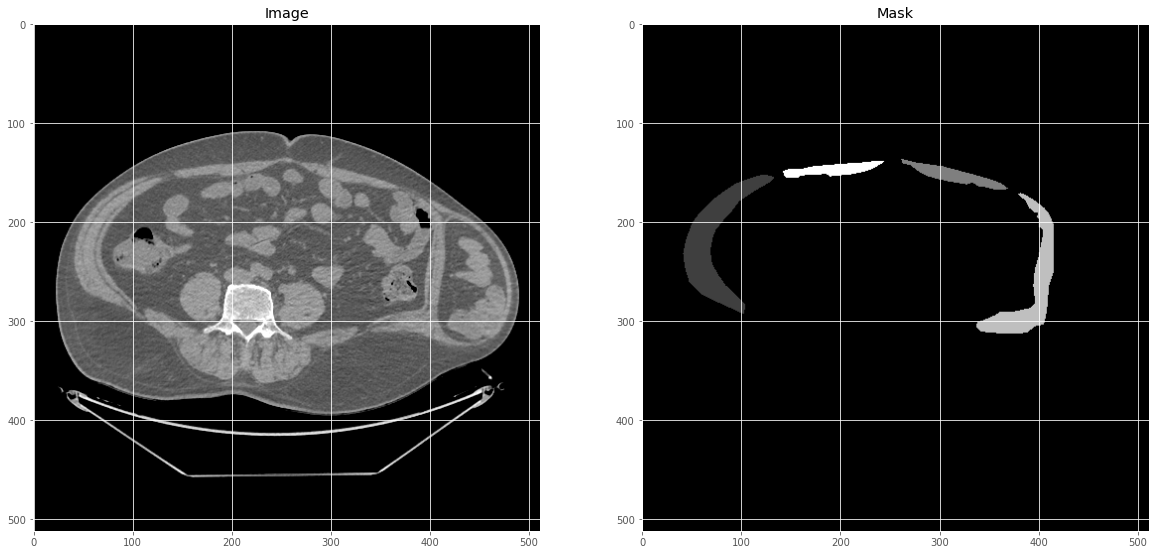

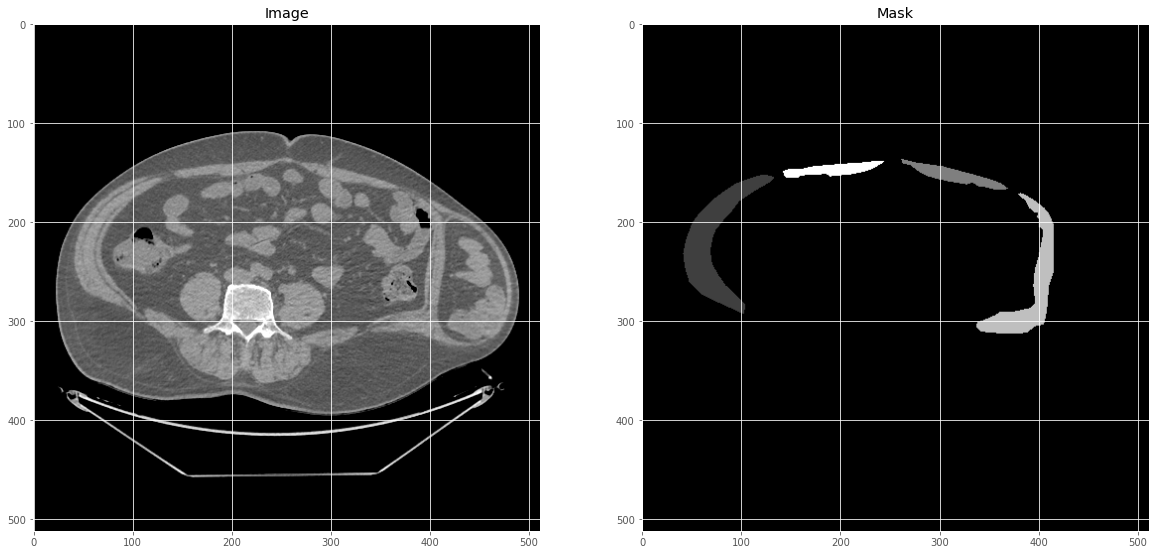

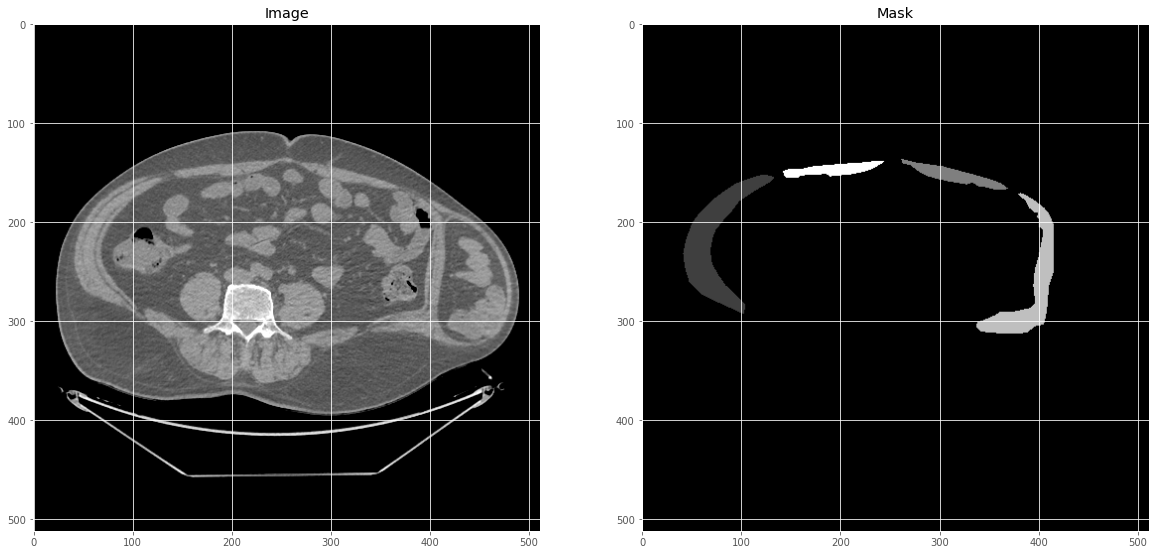

In [31]:
pre_visualize(X_test, y_test, test_text)

In [32]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [33]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1) 
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    p5 = MaxPooling2D((2, 2))(c5)
    p5 = Dropout(dropout)(p5)
    
    c6 = conv2d_block(p5, n_filters * 32, kernel_size = 3, batchnorm = batchnorm)
    p6 = MaxPooling2D((2, 2))(c6)
    p6 = Dropout(dropout)(p6)
    
    c7 = conv2d_block(p6, n_filters = n_filters * 64, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    
    u8 = Conv2DTranspose(n_filters * 32, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c6])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 32, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c5])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    u10 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c9)
    u10 = concatenate([u10, c4])
    u10 = Dropout(dropout)(u10)
    c10 = conv2d_block(u10, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u11 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c10)
    u11 = concatenate([u11, c3])
    u11 = Dropout(dropout)(u11)
    c11 = conv2d_block(u11, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u12 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c11)
    u12 = concatenate([u12, c2])
    u12 = Dropout(dropout)(u12)
    c12 = conv2d_block(u12, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u13 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c12)
    u13 = concatenate([u13, c1])
    u13 = Dropout(dropout)(u13)
    c13 = conv2d_block(u13, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c13)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [34]:
from keras import backend as K


def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    val = (2. * intersection + K.epsilon()) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + K.epsilon())
    return 1. - val

In [35]:
from keras import backend as K
def iou_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    val = (intersection + K.epsilon()) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) - intersection + K.epsilon())
    return 1. - val

In [36]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss=dice_loss, metrics=["accuracy"])

2022-11-08 02:32:25.083114: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [38]:
# load the best model
model.load_weights('baselines/model_all-tgs-salt.h5')

In [39]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_train, y_train, verbose=1)
model.evaluate(X_valid, y_valid, verbose=1)
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 5s 5s/step - loss: 0.1566 - accuracy: 0.9649


[0.15663838386535645, 0.9649291634559631]

In [40]:
# Predict on train, val and test
preds_train_all = model.predict(X_train, verbose=1)
preds_val_all = model.predict(X_valid, verbose=1)
preds_test_all = model.predict(X_test, verbose=1)

1/1 [==============================] - 5s 5s/step


In [41]:
# load the best model
model.load_weights('baselines/model_local-tgs-salt.h5')

In [42]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_train, y_train, verbose=1)
model.evaluate(X_valid, y_valid, verbose=1)
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 5s 5s/step - loss: 0.1574 - accuracy: 0.9646


[0.15735536813735962, 0.9645880460739136]

In [43]:
preds_train_local = model.predict(X_train, verbose=1)
preds_val_local = model.predict(X_valid, verbose=1)
preds_test_local = model.predict(X_test, verbose=1)

1/1 [==============================] - 5s 5s/step


In [44]:
range_1 = range(0,5) #02
range_2 = range(5,10) #41
range_3 = range(10,15) #25
range_4 = range(15,21) #34
range_5 = range(21,26)#02

In [59]:
#Function for viewing plots and predictions
def plot_sample_compare(X, y, preds_1, preds_2, text, temp_range = range(0, random.randint(0, len(X)-1)), ix=None):
    """Function to plot the results"""
    print(text) 
    
    total_dloss_global = 0.0
    total_dloss_local = 0.0
    total_iouloss_global = 0.0
    total_iouloss_local = 0.0
    
    count = 0
    
    for i in temp_range : 
        #if ix is None:
        ix = i
        count +=1
            
        fig, ax = plt.subplots(1, 4, figsize=(20, 10))
        ax[0].imshow(X[ix], cmap='gray')
        ax[0].set_title('Input')

        ax[1].imshow(y[ix].squeeze(),cmap='gray')
        ax[1].set_title('Mask')


        ax[2].imshow(preds_1[ix].squeeze(),cmap='gray')
        ax[2].set_title('Global Mask Predicted')
        
        ax[3].imshow(preds_2[ix].squeeze(),cmap='gray')
        ax[3].set_title('Local Mask Predicted')
        
        d1_loss = dice_loss(y[ix],preds_1[ix]).numpy()
        d1_loss = round(d1_loss*100, 3)
        
        d2_loss = dice_loss(y[ix],preds_2[ix]).numpy()
        d2_loss = round(d2_loss*100, 3)
        
        i1_loss = iou_loss(y[ix],preds_1[ix]).numpy()
        i1_loss = round(i1_loss*100, 3)
        
        i2_loss = iou_loss(y[ix],preds_2[ix]).numpy()
        i2_loss = round(i2_loss*100, 3)
        
        total_dloss_global += d1_loss
        total_dloss_local += d2_loss
        total_iouloss_global += i1_loss
        total_iouloss_local += i2_loss
        
        
        text_1 = "Dice loss of global image " + str(ix) +  " = " + str(d1_loss) + " %"
        text_3 = "Dice loss of local image " + str(ix) +  " = " + str(d2_loss) + " %"
        
        text_2 = "IoU loss of global image " + str(ix) +  " = " + str(i1_loss) + " %"
        text_4 = "IoU loss of local image " + str(ix) +  " = " + str(i2_loss) + " %"
        
        plt.figtext(0.4, 0.27, text_1, fontsize=18)
        plt.figtext(0.4, 0.24, text_3, fontsize=18)
        plt.figtext(0.4, 0.18, text_2, fontsize=18)
        plt.figtext(0.4, 0.15, text_4, fontsize=18)
    
    print("Average Global Dice loss : ", round(total_dloss_global/count,3))
    print("Average Local Dice loss : ", round(total_dloss_local/count,3))
    print("Average Global IOU loss : ", round(total_iouloss_global/count,3))
    print("Average Local IOU loss : ", round(total_iouloss_local/count,3))
        
        
        

						Training 
Average Global Dice loss :  3.092
Average Local Dice loss :  8.54
Average Global IOU loss :  5.991
Average Local IOU loss :  15.562


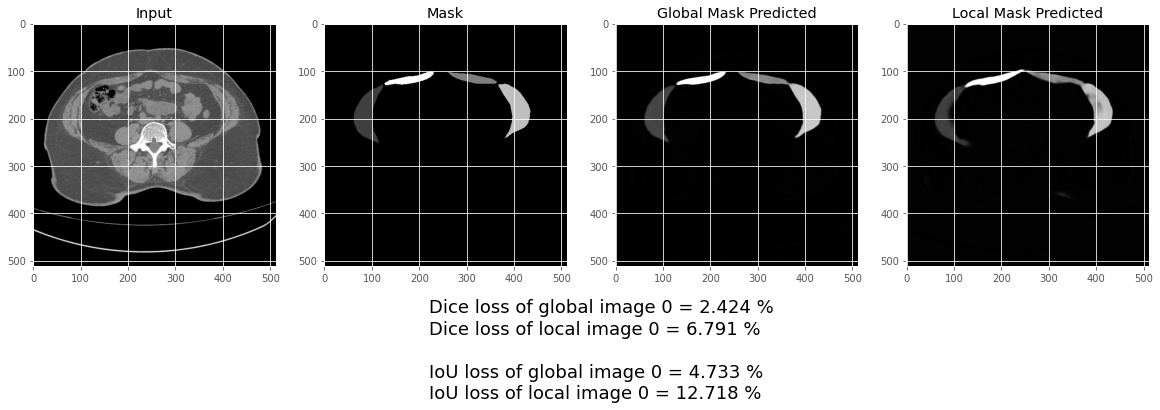

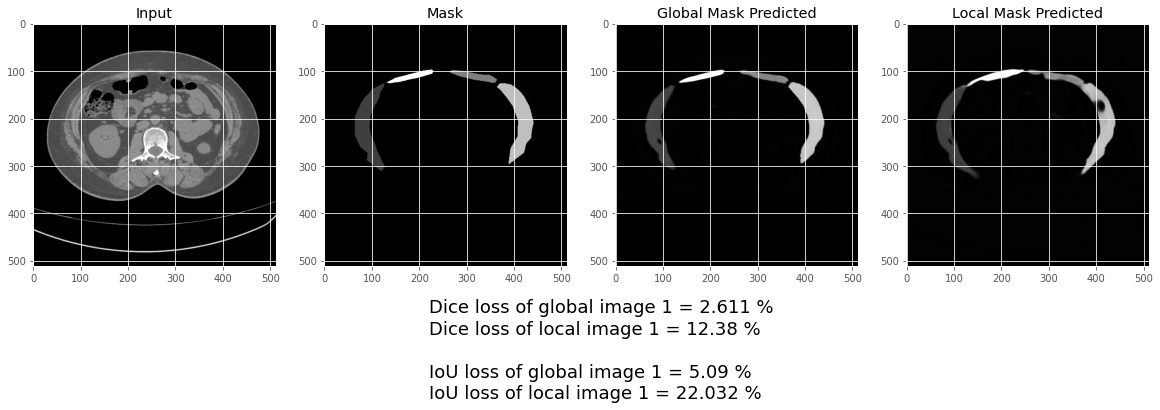

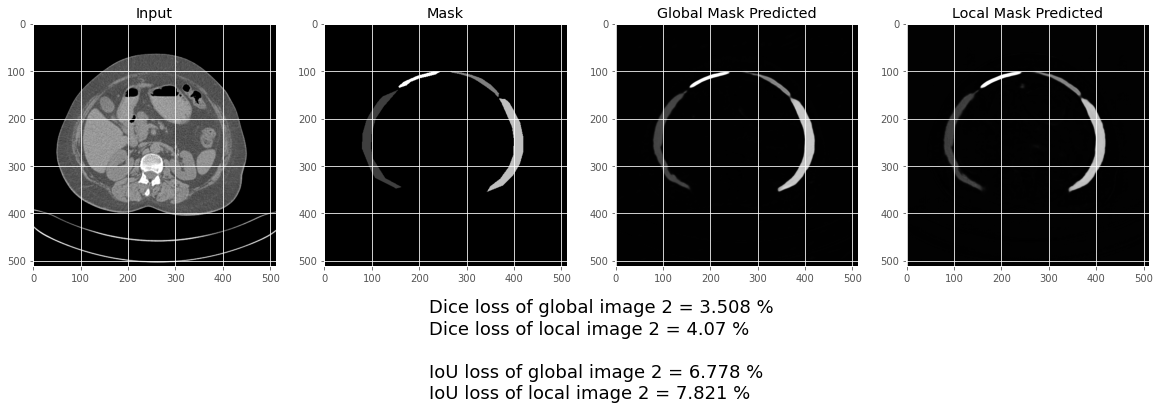

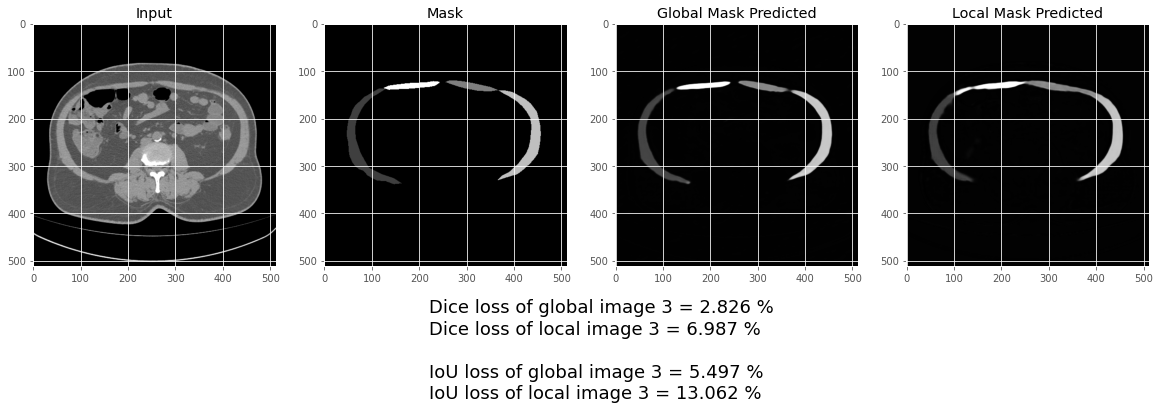

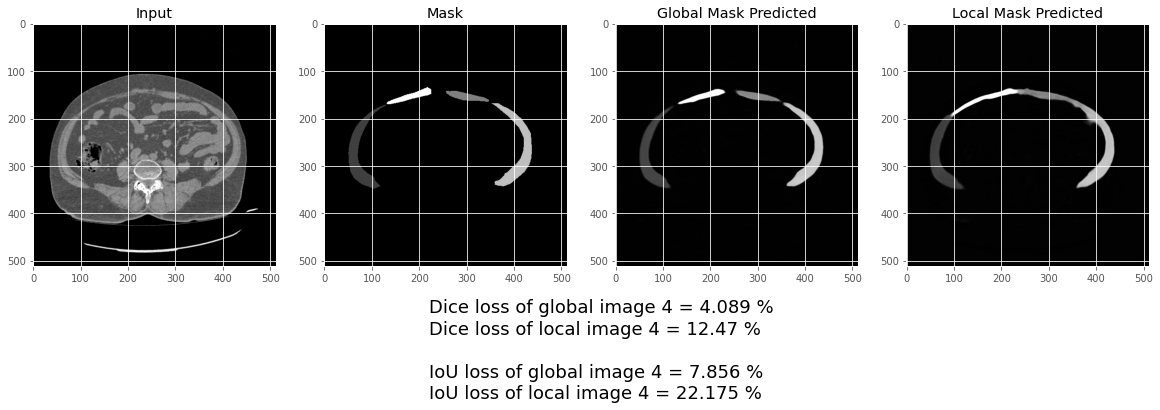

In [60]:
plot_sample_compare(X_train, y_train, preds_train_all, preds_train_local, train_text, range_1)

						Validation 
Average Global Dice loss :  3.042
Average Local Dice loss :  6.215
Average Global IOU loss :  5.903
Average Local IOU loss :  11.451


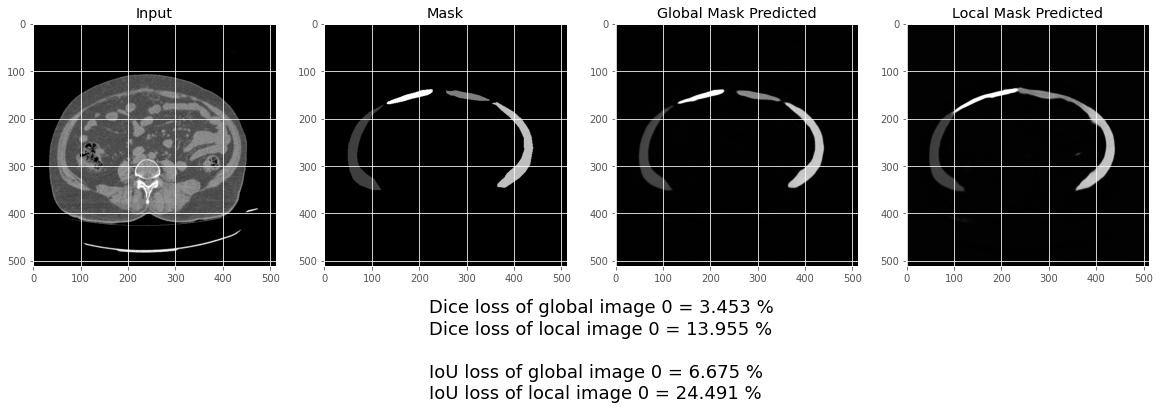

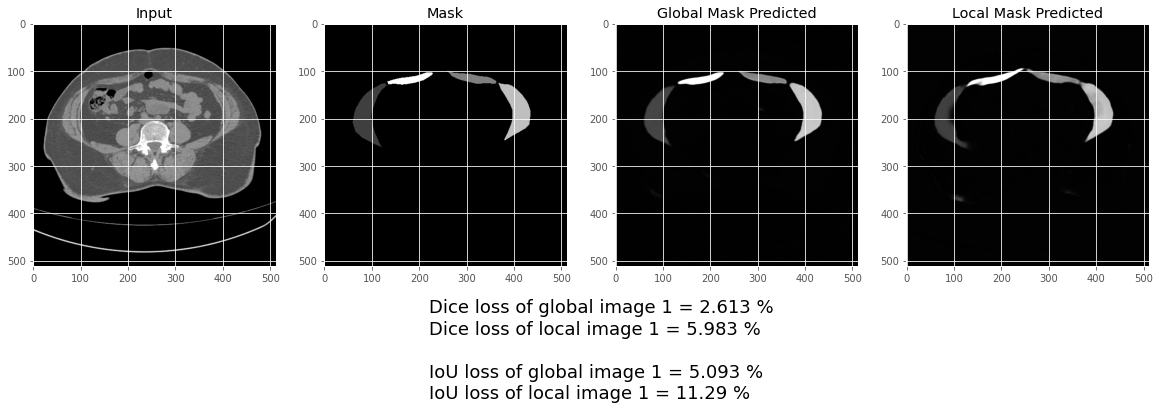

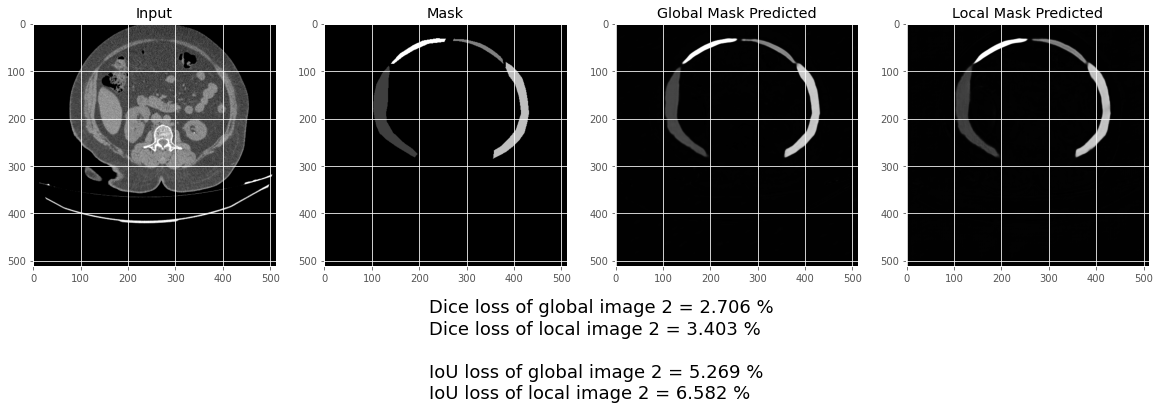

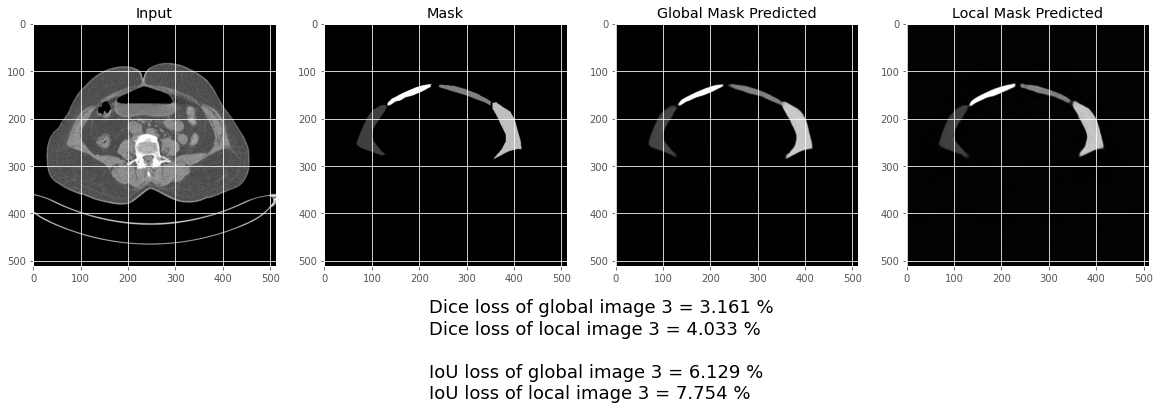

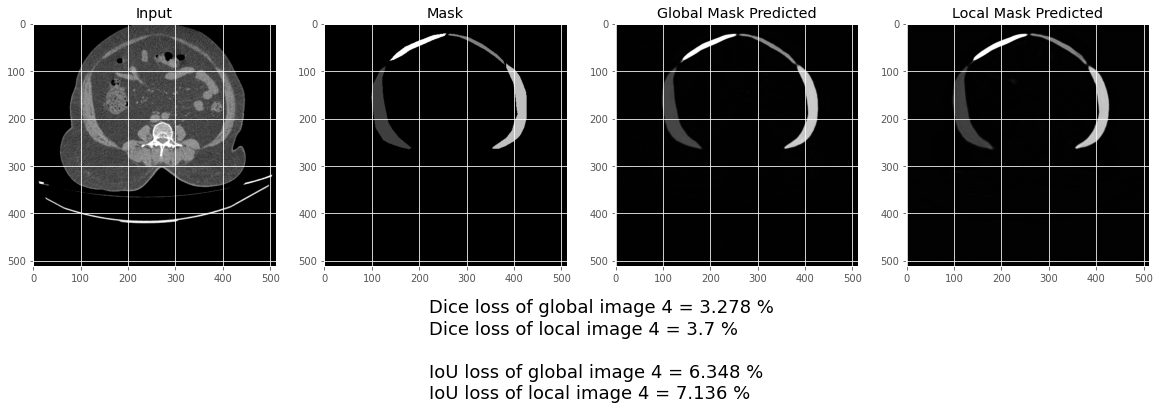

In [61]:
plot_sample_compare(X_valid, y_valid, preds_val_all, preds_val_local, valid_text, range_1)

							Testing 
Average Global Dice loss :  17.77
Average Local Dice loss :  15.952
Average Global IOU loss :  30.112
Average Local IOU loss :  27.474


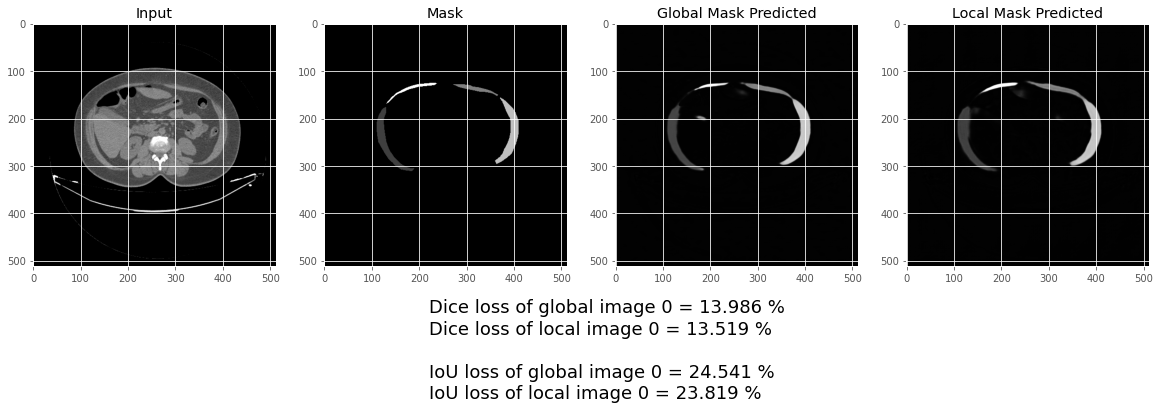

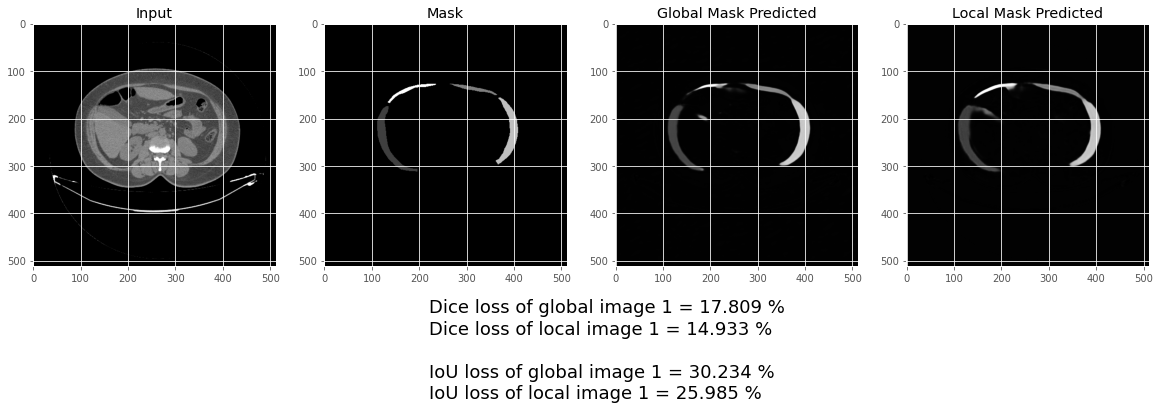

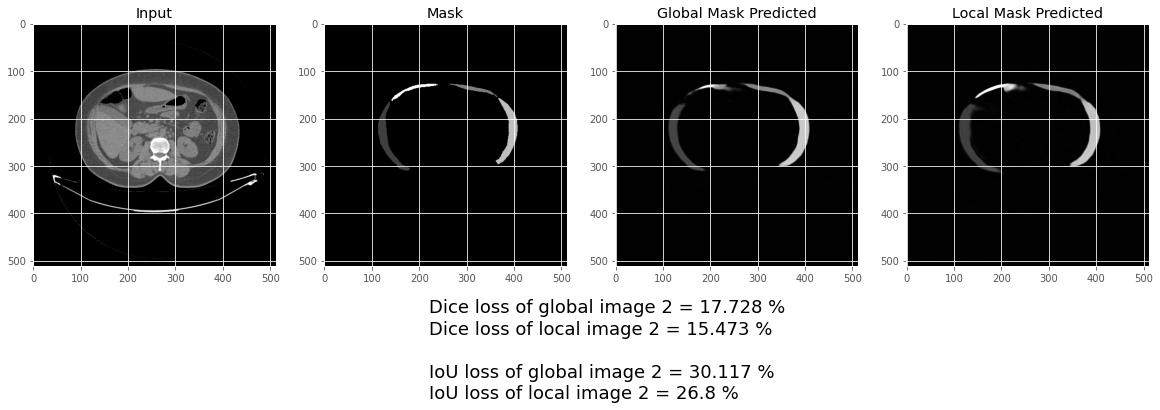

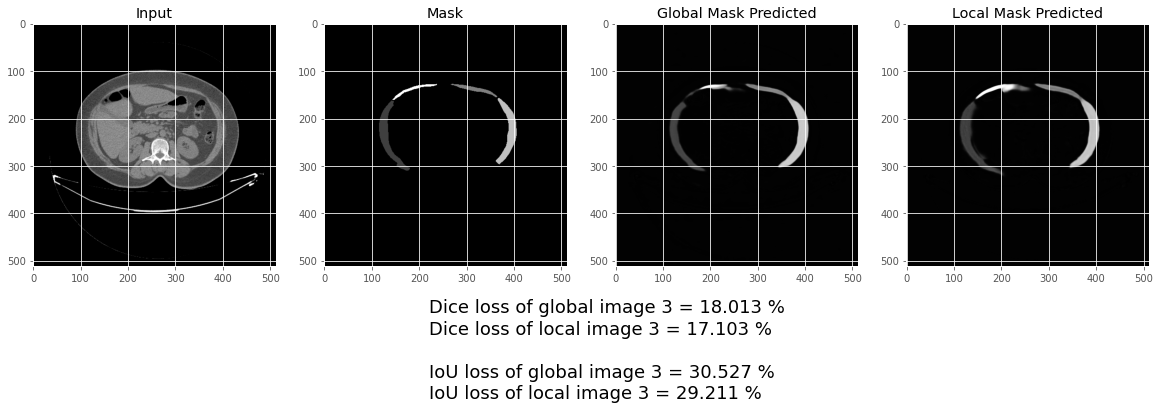

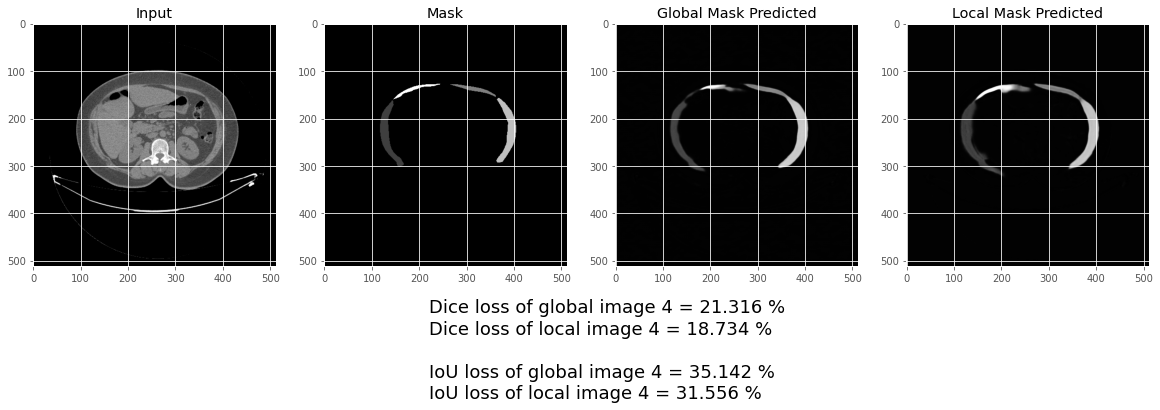

In [62]:
plot_sample_compare(X_test, y_test, preds_test_all, preds_test_local, test_text, range_1)

Range 2

							Testing 
Average Global Dice loss :  10.158
Average Local Dice loss :  10.111
Average Global IOU loss :  18.424
Average Local IOU loss :  18.356


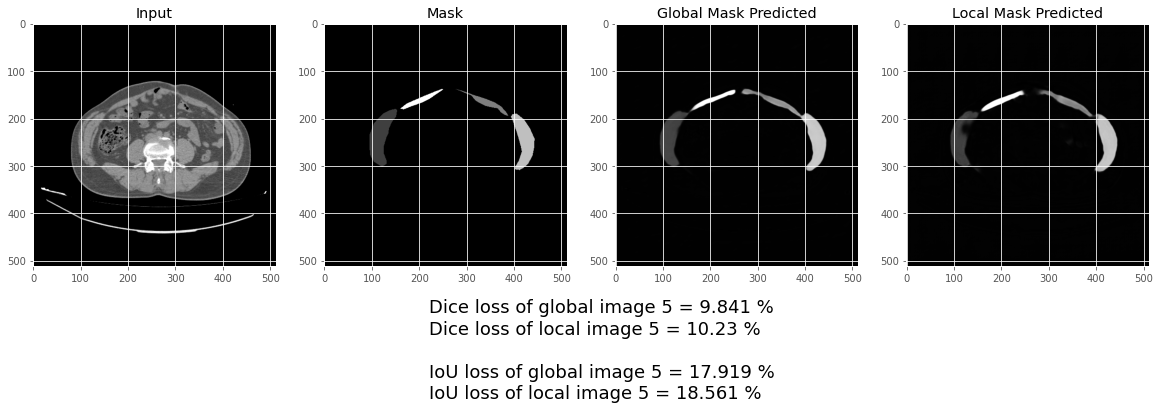

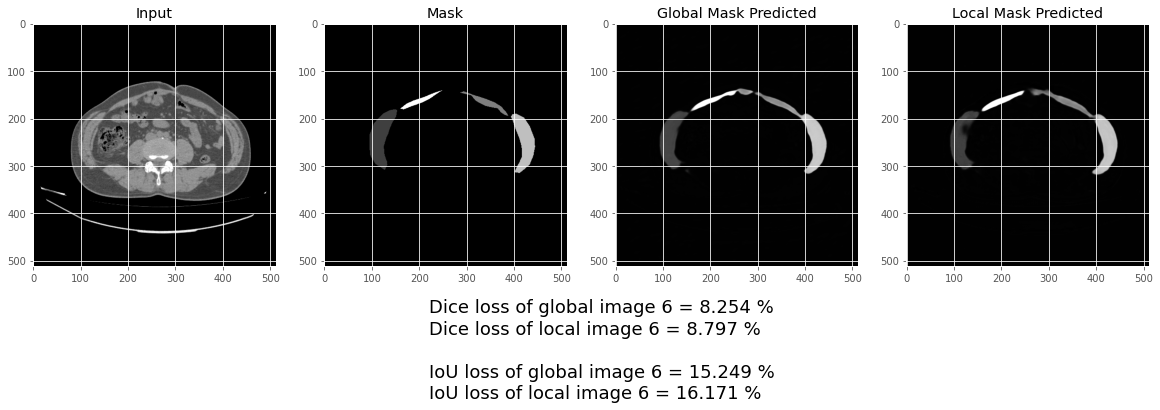

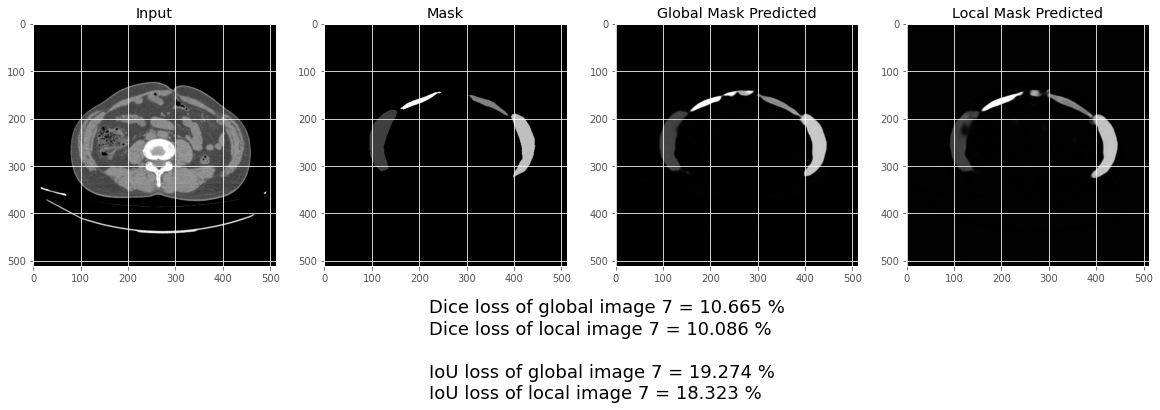

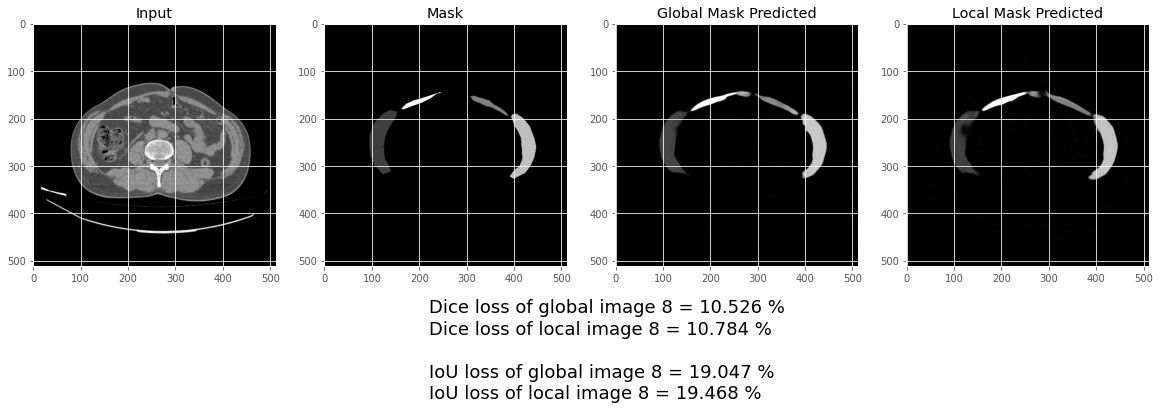

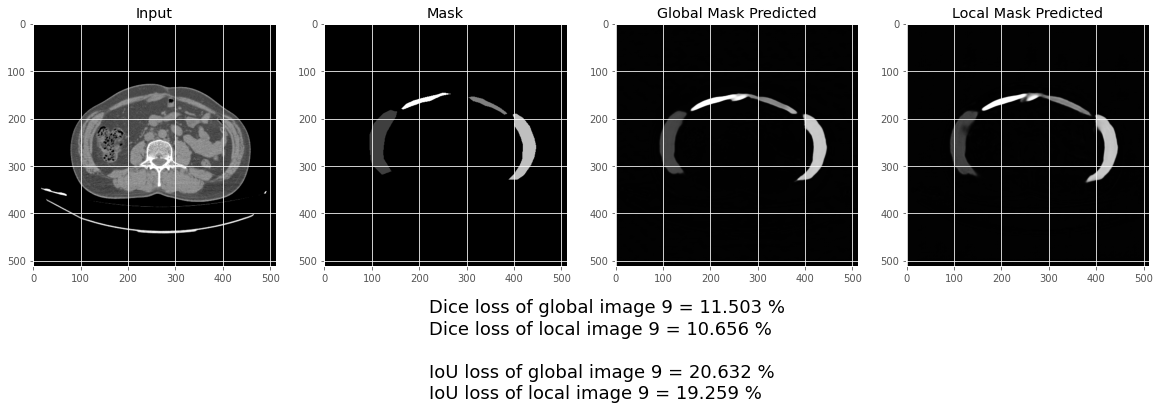

In [63]:
plot_sample_compare(X_test, y_test, preds_test_all, preds_test_local, test_text, range_2)

Range 3

							Testing 
Average Global Dice loss :  9.083
Average Local Dice loss :  10.197
Average Global IOU loss :  16.644
Average Local IOU loss :  18.504


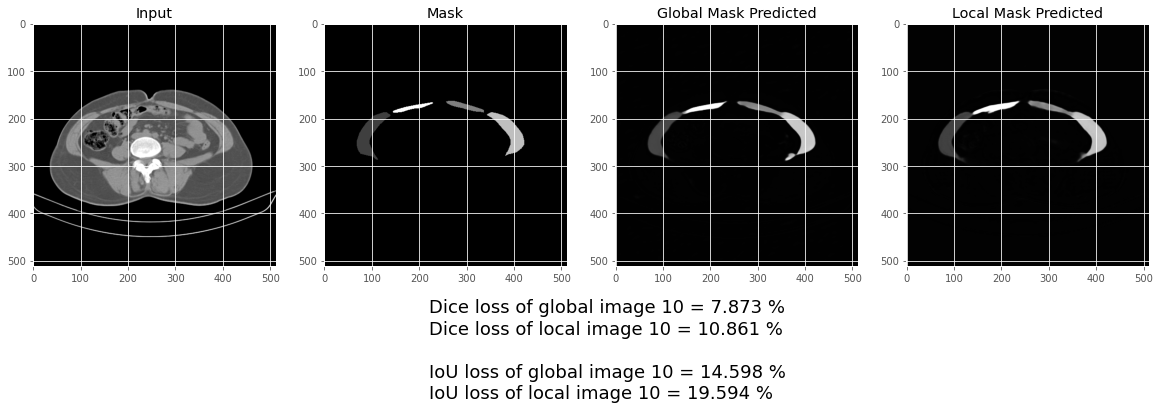

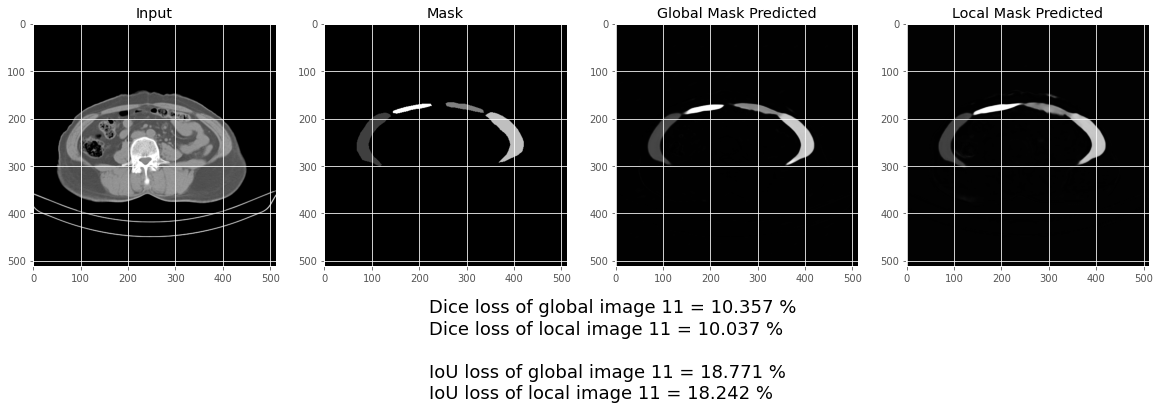

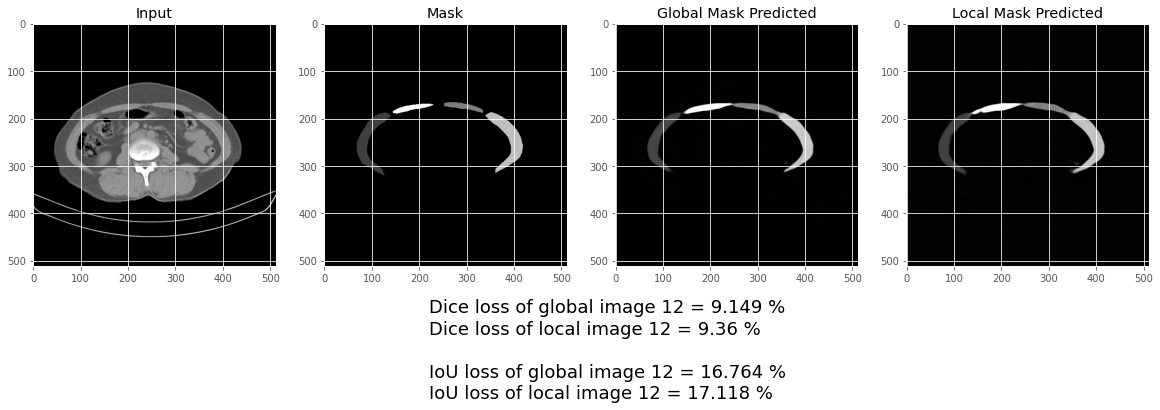

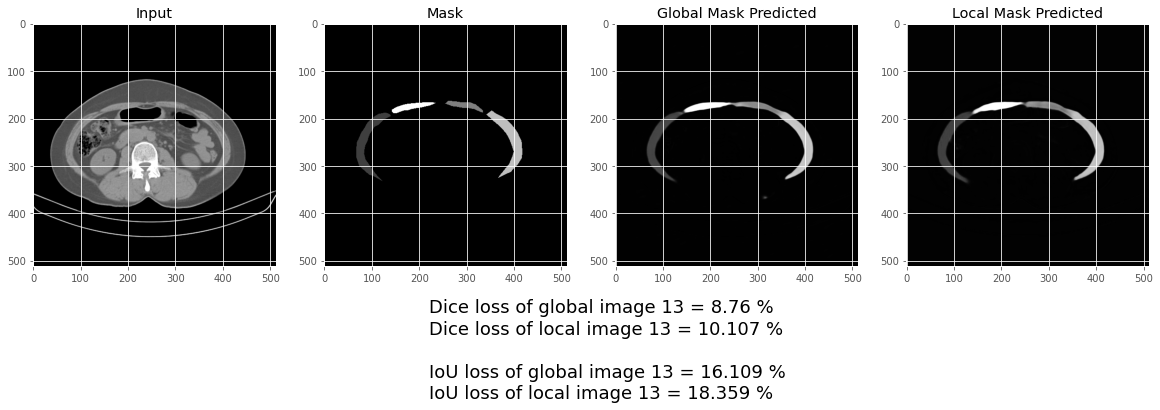

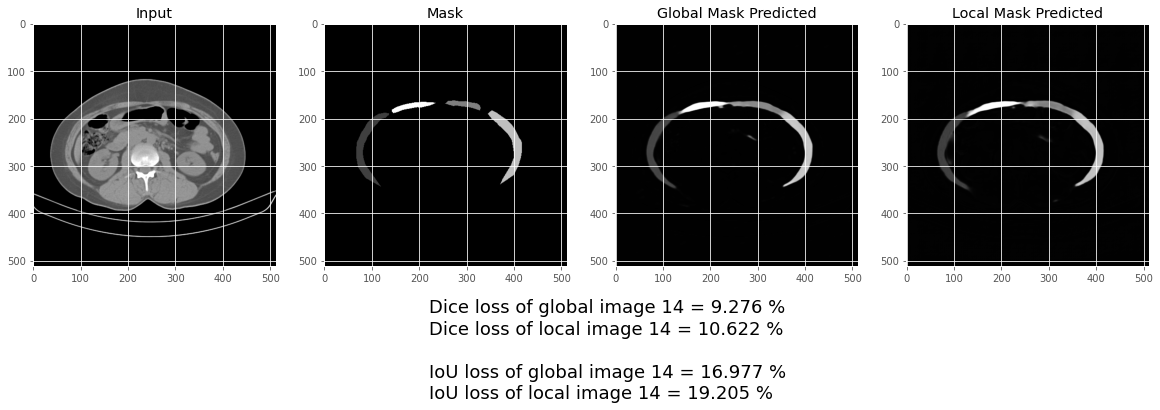

In [64]:
plot_sample_compare(X_test, y_test, preds_test_all, preds_test_local, test_text, range_3)

Range 4

							Testing 
Average Global Dice loss :  9.377
Average Local Dice loss :  6.638
Average Global IOU loss :  17.076
Average Local IOU loss :  12.414


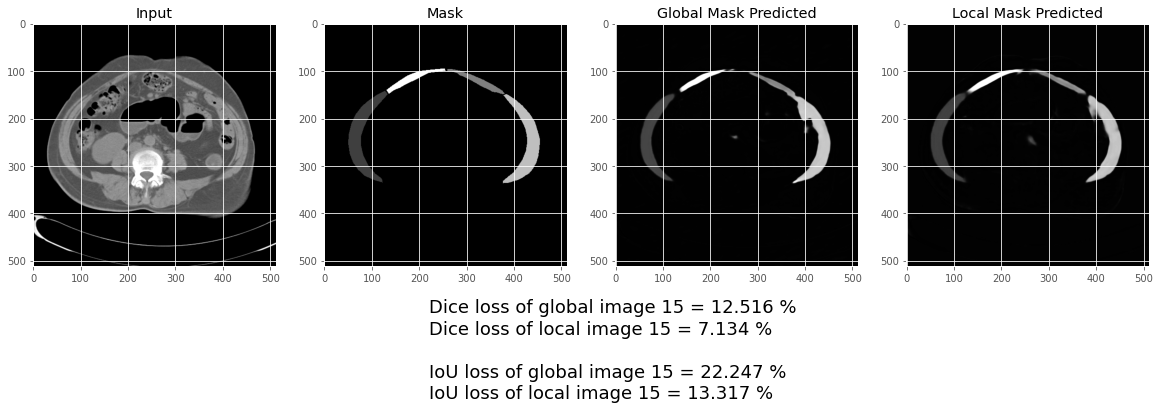

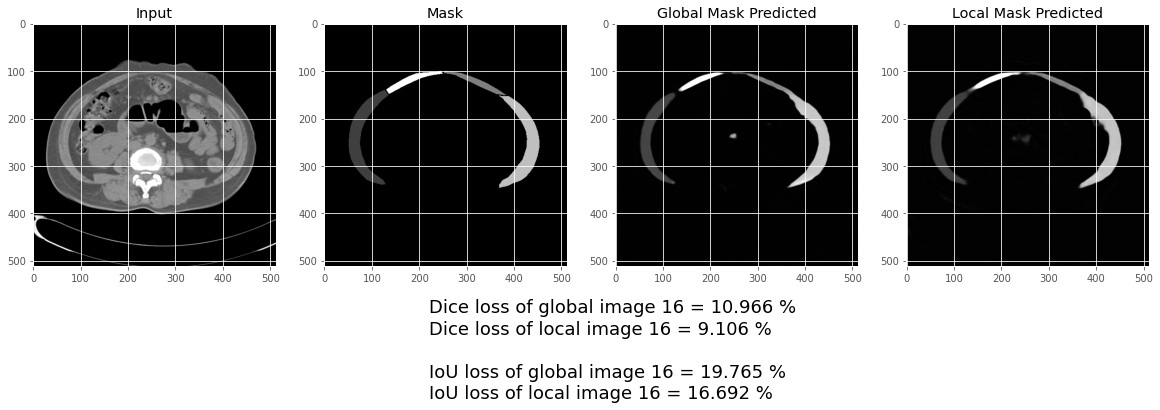

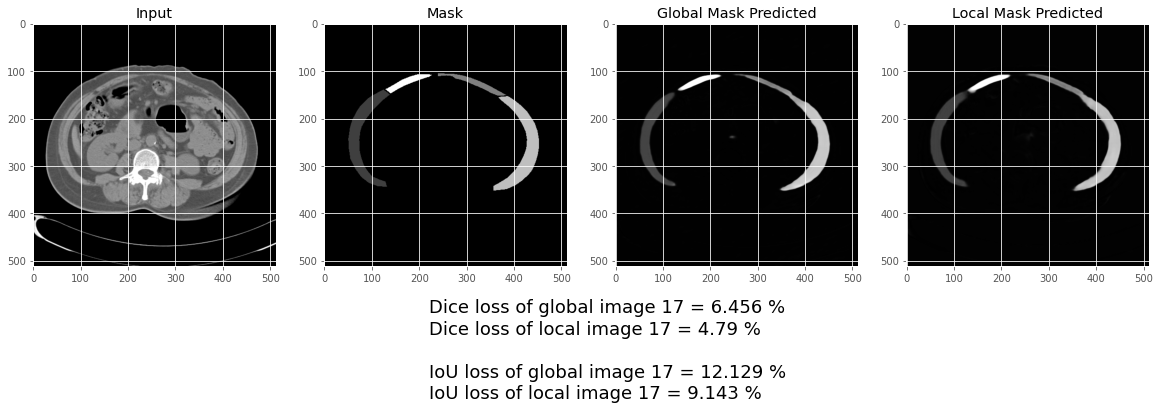

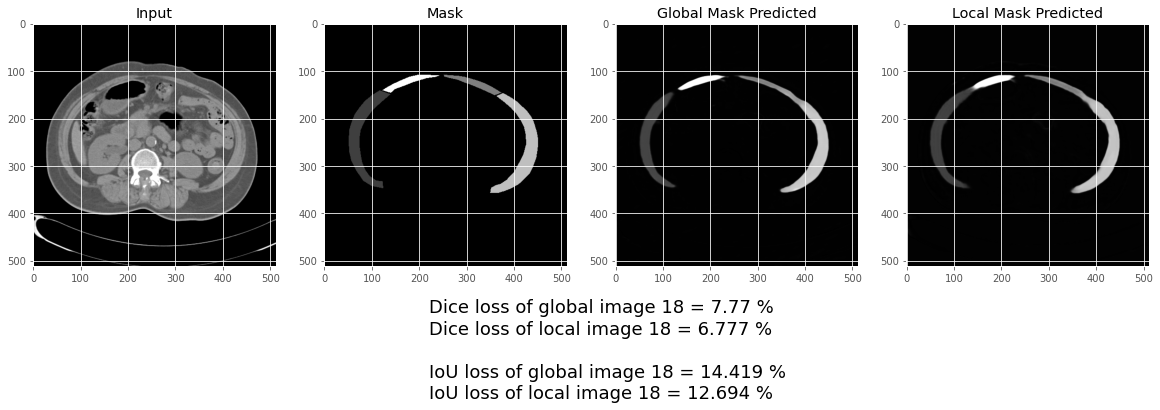

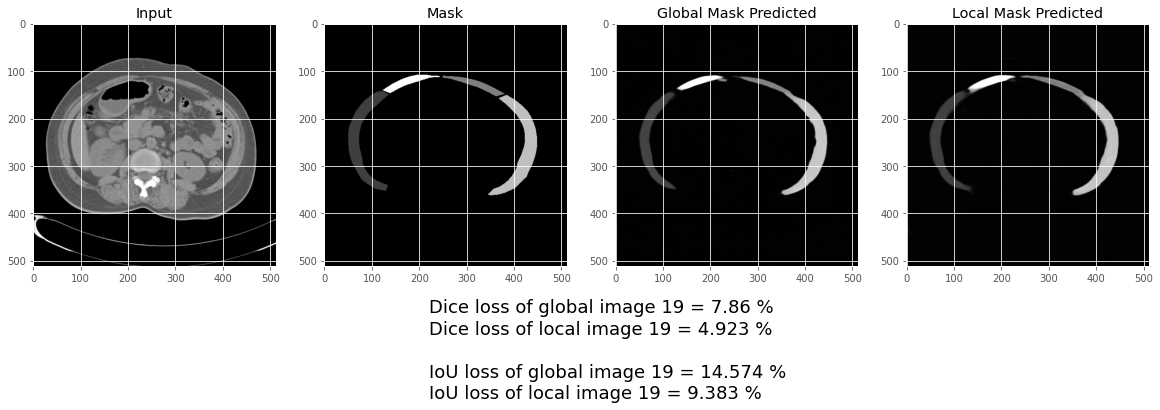

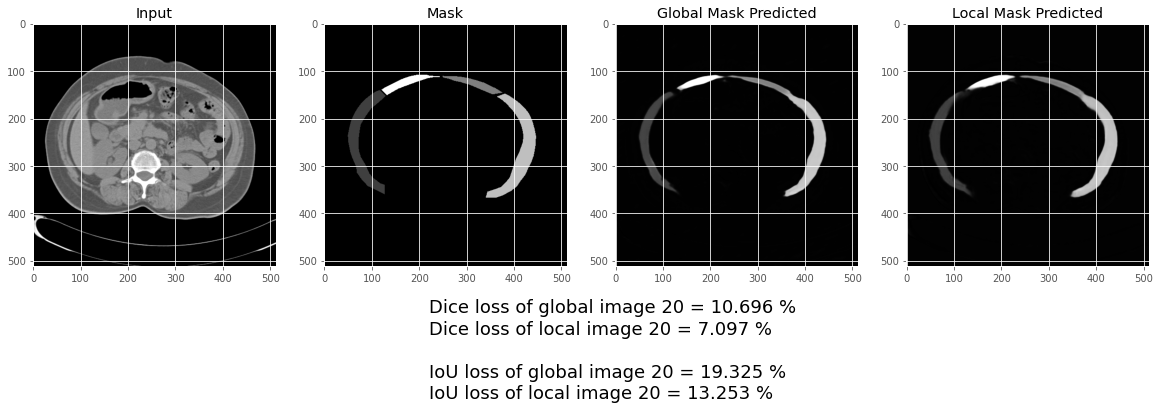

In [65]:
plot_sample_compare(X_test, y_test, preds_test_all, preds_test_local, test_text, range_4)

							Testing 
Average Global Dice loss :  40.066
Average Local Dice loss :  45.402
Average Global IOU loss :  57.134
Average Local IOU loss :  62.36


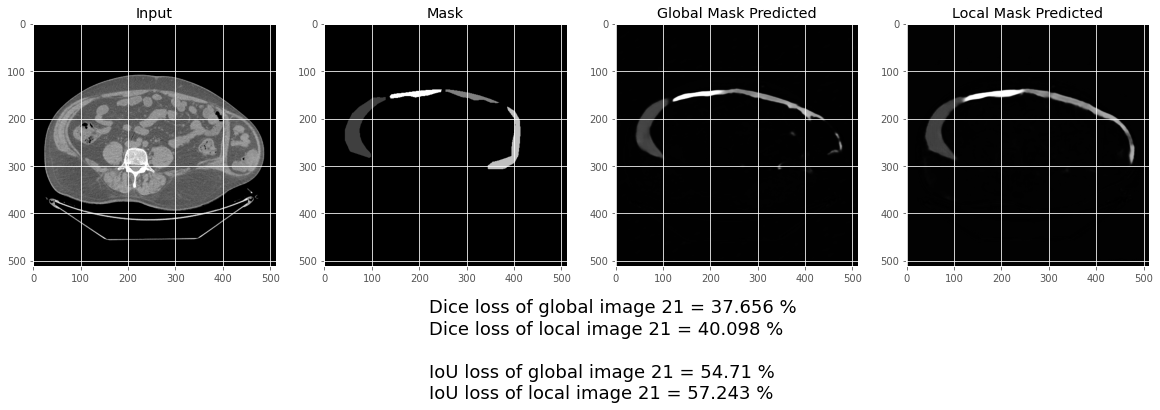

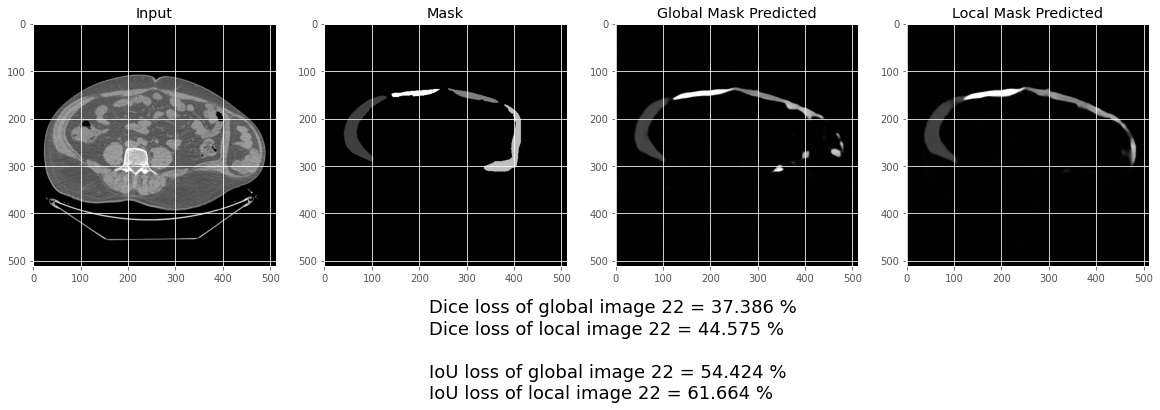

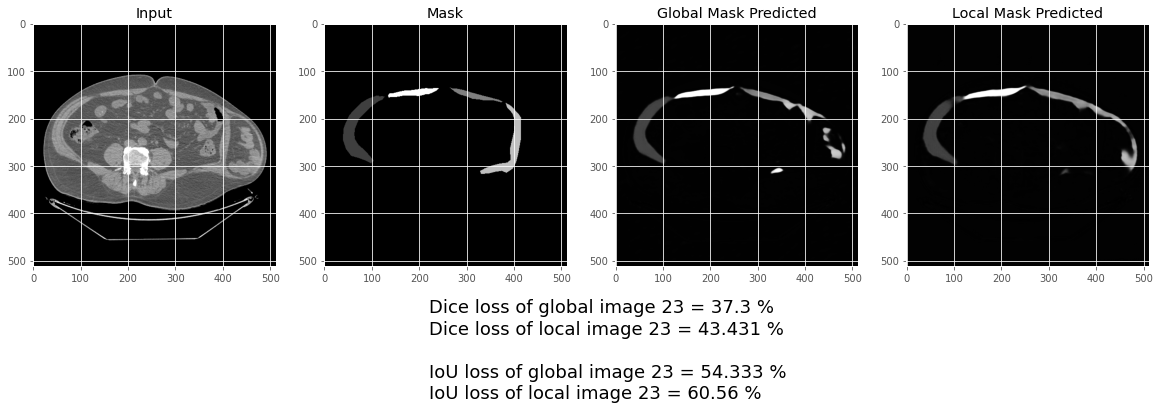

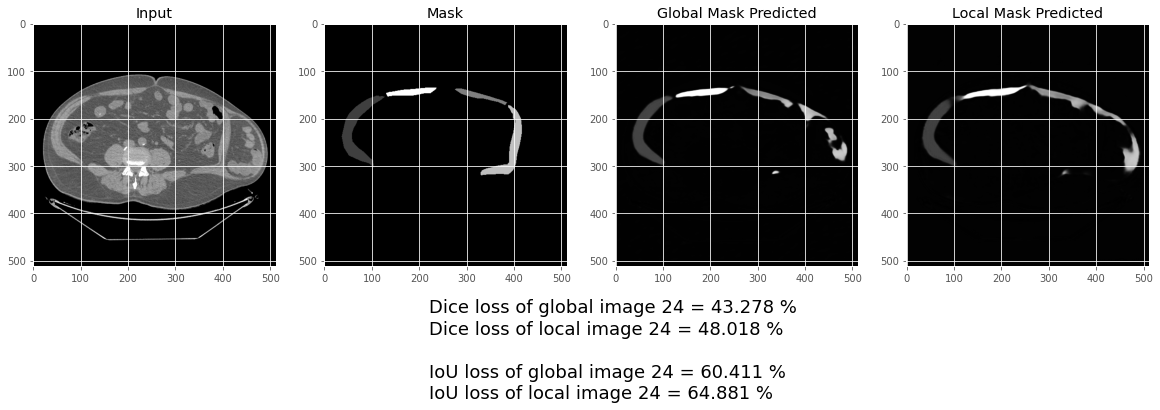

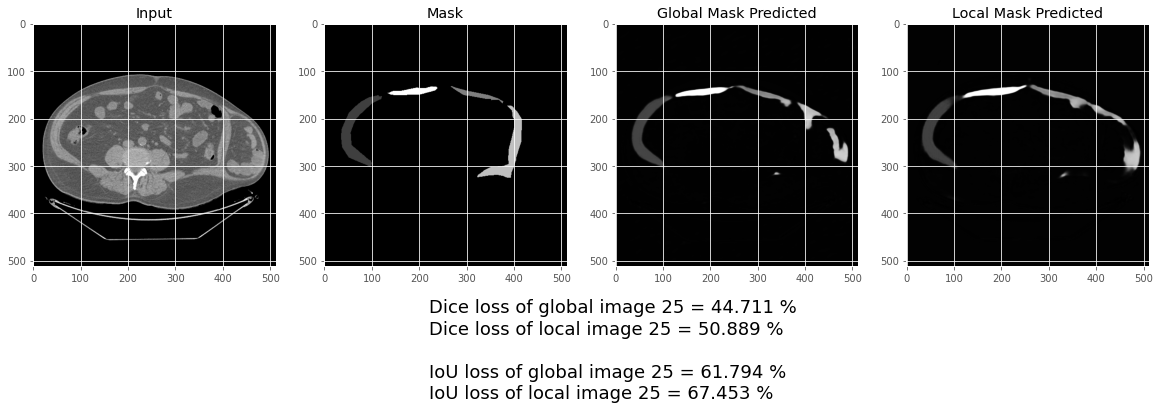

In [66]:
plot_sample_compare(X_test, y_test, preds_test_all, preds_test_local, test_text, range_5)